<a href="https://colab.research.google.com/github/instrat-pl/pypsa-pl-mini/blob/main/notebooks/pypsa_pl_mini_opex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyPSA-PL-mini: OPEX

Simplified energy modelling environment for rapid testing and education.

Example of OPEX optimisation.

Version 0.1

This notebook is released under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact person:** Patryk Kubiczek (patryk.kubiczek@instrat.pl)

## How to use it?

**Start by making your own copy of this notebook (File > Save a copy in Drive).** This notebook, containing an application of the the PyPSA-PL-mini model, is synchronised with the GitHub repository https://github.com/instrat-pl/pypsa-pl-mini. To play with the model, create your own copy of this notebook. 

[*General user*] 
Run the "Configuration" cells which will clone the PyPSA-PL-mini repository into your Google Colab space and which will install all the required libraries. This might take up to a few minutes. After the configuration is finished, you can proceed to experiment with PyPSA-PL-mini. Have fun!

## Configuration (run each cell just once)

In [1]:
import sys
import os

# Optionally install pl_PL.UTF-8 locale in Google Colab
# Source: https://stackoverflow.com/questions/67045349/change-locale-for-google-colab

skip_installing_pl_locale = True

if "google.colab" in sys.modules and not skip_installing_pl_locale:
  # Install pl_PL
  !/usr/share/locales/install-language-pack pl_PL.UTF-8
  !dpkg-reconfigure locales
    
  # Restart Python process to pick up the new locales
  os.kill(os.getpid(), 9)

In [2]:
import sys
import os
from pathlib import Path

instrat_user = False
force_installation = False

if "google.colab" in sys.modules:

  %cd "/content"

  if instrat_user:  
    
    from google.colab import drive
    root = "/content/drive"
    drive.mount(root)

    def project_dir(*path):
      return Path(root, "MyDrive", "Colab", "PyPSA-PL-mini", *path)

  else:
    
    from google.colab import userdata
    # ghtoken = userdata.get("GHTOKEN")

    !rm -rf pypsa-pl-mini
    # !git clone https://{ghtoken}@github.com/instrat-pl/pypsa-pl-mini.git
    !git clone https://github.com/instrat-pl/pypsa-pl-mini.git

    def project_dir(*path):
      return Path("/content", "pypsa-pl-mini", *path)

  %cd {str(project_dir())}

  if not instrat_user or force_installation:
    !pip install poetry --quiet
    !poetry config virtualenvs.in-project false
    !poetry config virtualenvs.path {str(project_dir("venv"))}
    !poetry install --no-ansi
    # ipywidgets have to be downgraded in Google Colab
    !poetry add ipywidgets@7.7.2 --no-ansi
    # Download and install Work Sans font
    !mkdir fonts
    !cd fonts  
    !wget https://github.com/weiweihuanghuang/Work-Sans/raw/master/fonts/ttf/WorkSans-Regular.ttf
    !wget https://github.com/weiweihuanghuang/Work-Sans/raw/master/fonts/ttf/WorkSans-Medium.ttf
    from matplotlib import font_manager
    font_files = ["WorkSans-Regular.ttf", "WorkSans-Medium.ttf"]
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    !cd ..

  v = f"{sys.version_info.major}.{sys.version_info.minor}"
  venv_location = !poetry env info -p
  VENV_PATH = os.path.join(venv_location[0], "lib", f"python{v}", "site-packages")
  sys.path.insert(0, VENV_PATH)  
  
  SRC_PATH = str(project_dir("src"))
  sys.path.insert(0, SRC_PATH)

else:
  %load_ext autoreload
  %autoreload 2

import pypsa_pl_mini.config

## Power system model

### Specify parameters

In [3]:
params = {
    # Run name and year
    "run_name": "pypsa_pl_mini_opex",
    "year": 2023,
    # Input data
    "technology_carrier_definitions": "mini",
    "technology_cost_data": "instrat_2024",
    "installed_capacity": "historical_totals",
    "annual_energy_flows": "historical",
    "capacity_utilisation": "historical",
    # Other assumptions
    "investment_technologies": [],
    "retirement_technologies": [],
    "constrained_energy_flows": [],
    "weather_year": 2012,
    "share_space_heating": 0.8,
    "prosumer_self_consumption": 0.2,
    "discount_rate": 0.03, # irrelevant in this example
    "reoptimise_with_fixed_capacities": False, # capacities are always fixed in this example
    # Technical details
    "inf": 100000,
    "reverse_links": True,
    "solver": "highs",
}

### Prepare inputs


In [4]:
from pypsa_pl_mini.build_network import load_and_preprocess_inputs


def custom_operation(inputs):

    def add_qualifier_to_technology(df, technology, qualifier):
        df.loc[df["technology"] == technology, "qualifier"] = qualifier
        return df

    # Identify solar PV roof as prosumer electricity source
    inputs["installed_capacity"] = add_qualifier_to_technology(
        inputs["installed_capacity"],  "solar PV roof", "prosumer",
    )

    
    def remove_capacities(df, technologies):
        df = df[~df["technology"].isin(technologies)]
        return df

    # We do not model cross border electricity flows in this simplified example
    inputs["installed_capacity"] = remove_capacities(
        inputs["installed_capacity"],
        technologies=[
            "electricity export AC",
            "electricity import AC",
            "electricity export DC",
            "electricity import DC",
        ],
    )

    return inputs


inputs = load_and_preprocess_inputs(params, custom_operation=custom_operation)

2024-04-22 10:24:28 [INFO] NumExpr defaulting to 8 threads.


In [5]:
# name = "technology_carrier_definitions"
# name = "technology_cost_data"
# name = "installed_capacity"
# name = "annual_energy_flows"
# name = "capacity_utilisation"
# name = "co2_cost"
name = "final_use"

inputs[name]

parameter,area,carrier,year,p_set_annual
0,PL,electricity final use,2022,18310.502283
1,PL,electricity final use,2023,17614.155251


### Create PyPSA network

In [6]:
from pypsa_pl_mini.build_network import create_custom_network

network = create_custom_network(params)

network

Empty PyPSA Network 'pypsa_pl_mini_opex'
Components: none
Snapshots: 1

### Add snapshots

In [7]:
from pypsa_pl_mini.build_network import add_snapshots

add_snapshots(network, params)

network.snapshots

Index(['2012-03-09 00:00:00', '2012-03-09 01:00:00', '2012-03-09 02:00:00',
       '2012-03-09 03:00:00', '2012-03-09 04:00:00', '2012-03-09 05:00:00',
       '2012-03-09 06:00:00', '2012-03-09 07:00:00', '2012-03-09 08:00:00',
       '2012-03-09 09:00:00',
       ...
       '2012-11-01 14:00:00', '2012-11-01 15:00:00', '2012-11-01 16:00:00',
       '2012-11-01 17:00:00', '2012-11-01 18:00:00', '2012-11-01 19:00:00',
       '2012-11-01 20:00:00', '2012-11-01 21:00:00', '2012-11-01 22:00:00',
       '2012-11-01 23:00:00'],
      dtype='object', name='snapshot', length=672)

### Add carriers

In [8]:
from pypsa_pl_mini.build_network import add_carriers

add_carriers(network, inputs, params)

network.carriers

,color,order,aggregation,co2_emissions,nice_name,max_growth,max_relative_growth
Carrier,,,,,,,
DSR reduction,#1b1c1e,191,DSR,NaN,,inf,0.0
battery large charger,#458aff,142,battery large,NaN,,inf,0.0
battery large power,#458aff,141,battery large,NaN,,inf,0.0
battery large storage,#458aff,140,battery large,NaN,,inf,0.0
biogas CHP,#816d66,82,biomass and biogas CHP,NaN,,inf,0.0
biogas production,#816d66,81,biomass and biogas supply,NaN,,inf,0.0
biogas substrate supply,#816d66,80,biomass and biogas supply,NaN,,inf,0.0
biomass agriculture CHP,#ab9d99,71,biomass and biogas CHP,NaN,,inf,0.0
biomass agriculture supply,#ab9d99,70,biomass and biogas supply,NaN,,inf,0.0


### Add buses

In [9]:
from pypsa_pl_mini.build_network import add_buses

add_buses(network, inputs, params)

network.buses

,area,carrier,v_nom,type,x,y,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,
PL battery large electricity,PL,battery large electricity,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biogas,PL,biogas,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biogas substrate,PL,biogas substrate,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biomass wood,PL,biomass wood,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL electricity,PL,electricity,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL hard coal,PL,hard coal,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL hydro PSH electricity,PL,hydro PSH electricity,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL lignite,PL,lignite,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL natural gas,PL,natural gas,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,


### Add generating, consuming, and storing capacity (generators, links, stores)

#### Process installed capacity data and specify the relevant attributes

In [10]:
from pypsa_pl_mini.build_network import process_capacity_data

df_cap = process_capacity_data(inputs, params)

df_cap.head()

,name,area,technology,qualifier,build_year,retire_year,cumulative,nom,carrier,aggregation,...,p_nom_extendable,p_nom_min,p_nom_max,e_nom_extendable,e_nom_min,e_nom_max,p_set_annual,p_min_pu,p_max_pu,p_set
1,PL battery large charger 2023,PL,battery large charger,NaN,2023,2023,True,140.0,battery large charger,battery large,...,False,140.0,140.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN
0,PL battery large power 2023,PL,battery large power,NaN,2023,2023,True,150.0,battery large power,battery large,...,False,150.0,150.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN
2,PL battery large storage 2023,PL,battery large storage,NaN,2023,2023,True,600.0,battery large storage,battery large,...,NaN,NaN,NaN,False,600.0,600.0,NaN,0.0,1.0,NaN
3,PL biogas CHP industrial 2023,PL,biogas CHP,industrial,2023,2023,True,70.0,biogas CHP,biomass and biogas CHP,...,False,70.0,70.0,NaN,NaN,NaN,NaN,0.0,1.0,34.3
4,PL biogas CHP public 2023,PL,biogas CHP,public,2023,2023,True,210.0,biogas CHP,biomass and biogas CHP,...,False,210.0,210.0,NaN,NaN,NaN,113.4,0.0,1.0,NaN


#### Specify which attributes are time dependent

In [11]:
from pypsa_pl_mini.define_time_dependent_attributes import (
    define_time_dependent_attributes,
)


df_attr_t = define_time_dependent_attributes(df_cap, params)

df_attr_t

,carrier,qualifier,attribute,profile_type
0,electricity final use,none,p_set,electricity final use load profile
1,biogas CHP,public,p_set,heat final use load profile
2,biomass wood CHP,public,p_set,heat final use load profile
3,hard coal CHP,public,p_set,heat final use load profile
4,natural gas CHP,public,p_set,heat final use load profile
5,solar PV ground,none,p_max_pu,vres availability profile
6,solar PV roof,prosumer,p_max_pu,vres availability profile
7,wind onshore,none,p_max_pu,vres availability profile
8,biogas CHP,industrial,p_set,constant load profile
9,biogas production,industrial,p_set,constant load profile


#### Create actual components and fill them with data

In [12]:
from pypsa_pl_mini.build_network import add_capacities

add_capacities(network, df_cap, df_attr_t, params)

In [13]:
network.generators.head()

,bus,area,carrier,technology,qualifier,aggregation,p_nom,p_nom_extendable,p_nom_min,p_nom_max,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
PL biogas substrate supply 2023,PL biogas substrate,PL,biogas substrate supply,biogas substrate supply,,biomass and biogas supply,100000.0,False,100000.0,100000.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL biomass wood supply 2023,PL biomass wood,PL,biomass wood supply,biomass wood supply,,biomass and biogas supply,100000.0,False,100000.0,100000.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL electricity final use 2023,PL electricity,PL,electricity final use,electricity final use,,electricity final use,100000.0,False,100000.0,100000.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL hard coal supply 2023,PL hard coal,PL,hard coal supply,hard coal supply,,hard coal supply,100000.0,False,100000.0,100000.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL hydro ROR 2023,PL electricity,PL,hydro ROR,hydro ROR,,hydro ROR,600.0,False,600.0,600.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [14]:
network.generators_t.p_max_pu.head()

Generator,PL solar PV ground 2023,PL solar PV roof 2023,PL wind onshore 2023,PL wind onshore old 2023
snapshot,,,,
2012-03-09 00:00:00,0.0,0.0,0.397477,0.354552
2012-03-09 01:00:00,0.0,0.0,0.384946,0.342663
2012-03-09 02:00:00,0.0,0.0,0.373421,0.331774
2012-03-09 03:00:00,0.0,0.0,0.359752,0.318914
2012-03-09 04:00:00,0.0,0.0,0.367119,0.325837


In [15]:
network.generators_t.p_set.head()

Generator,PL electricity final use 2023,PL hydro ROR 2023
snapshot,,
2012-03-09 00:00:00,16821.518265,276.0
2012-03-09 01:00:00,16240.251142,276.0
2012-03-09 02:00:00,16028.881279,276.0
2012-03-09 03:00:00,16011.267123,276.0
2012-03-09 04:00:00,16240.251142,276.0


In [16]:
network.links.head()

,bus0,bus1,area,carrier,technology,qualifier,aggregation,p_nom,p_nom_extendable,p_nom_min,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
PL battery large charger 2023,PL battery large electricity,PL electricity,PL,battery large charger,battery large charger,,battery large,140.0,False,140.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL battery large power 2023,PL electricity,PL battery large electricity,PL,battery large power,battery large power,,battery large,150.0,False,150.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL biogas CHP industrial 2023,PL electricity,PL biogas,PL,biogas CHP,biogas CHP,industrial,biomass and biogas CHP,70.0,False,70.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL biogas CHP public 2023,PL electricity,PL biogas,PL,biogas CHP,biogas CHP,public,biomass and biogas CHP,210.0,False,210.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL biogas production industrial 2023,PL biogas,PL biogas substrate,PL,biogas production,biogas production,industrial,biomass and biogas supply,180.0,False,180.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [17]:
network.links_t.p_set.head()

Link,PL biogas CHP industrial 2023,PL biogas CHP public 2023,PL biogas production industrial 2023,PL biomass wood CHP industrial 2023,PL biomass wood CHP public 2023,PL hard coal CHP industrial 2023,PL hard coal CHP public 2023,PL natural gas CHP old industrial 2023,PL natural gas CHP old public 2023,PL other CHP industrial 2023
snapshot,,,,,,,,,,
2012-03-09 00:00:00,-34.3,-177.44832,-88.2,-182.0,-260.0,-236.9,-2191.97184,-785.2,-1565.42592,-275.0
2012-03-09 01:00:00,-34.3,-179.17200,-88.2,-182.0,-260.0,-236.9,-2213.26400,-785.2,-1580.63200,-275.0
2012-03-09 02:00:00,-34.3,-180.35136,-88.2,-182.0,-260.0,-236.9,-2227.83232,-785.2,-1591.03616,-275.0
2012-03-09 03:00:00,-34.3,-185.25024,-88.2,-182.0,-260.0,-236.9,-2288.34688,-785.2,-1634.25344,-275.0
2012-03-09 04:00:00,-34.3,-196.13664,-88.2,-182.0,-260.0,-236.9,-2422.82368,-785.2,-1730.29184,-275.0


In [18]:
network.links.p_max_pu

Link
PL battery large charger 2023            -0.00
PL battery large power 2023              -0.00
PL biogas CHP industrial 2023            -0.00
PL biogas CHP public 2023                -0.00
PL biogas production industrial 2023     -0.00
PL biogas production public 2023         -0.00
PL biomass wood CHP industrial 2023      -0.00
PL biomass wood CHP public 2023          -0.00
PL biomass wood power public 2023        -0.25
PL hard coal CHP industrial 2023         -0.00
PL hard coal CHP public 2023             -0.00
PL hard coal power SC public 2023        -0.25
PL hard coal power old public 2023       -0.25
PL hydro PSH power 2023                  -0.00
PL hydro PSH pump 2023                   -0.00
PL lignite power SC public 2023          -0.25
PL lignite power old public 2023         -0.25
PL natural gas CHP old industrial 2023   -0.00
PL natural gas CHP old public 2023       -0.00
PL other CHP industrial 2023             -0.00
Name: p_max_pu, dtype: float64

In [19]:
network.stores.head()

,bus,area,carrier,technology,qualifier,aggregation,e_nom,e_nom_extendable,e_nom_min,e_nom_max,...,e_max_pu,e_initial,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,marginal_cost_quadratic,standing_loss,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
PL battery large storage 2023,PL battery large electricity,PL,battery large storage,battery large storage,,battery large,600.0,False,600.0,600.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0,0.0
PL hydro PSH storage 2023,PL hydro PSH electricity,PL,hydro PSH storage,hydro PSH storage,,hydro PSH,8470.0,False,8470.0,8470.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0,0.0


### Add flow constraints

In [20]:
from pypsa_pl_mini.build_network import add_energy_flow_constraints

add_energy_flow_constraints(network, inputs, params)

# No flow constraints are added by default
network.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,


### Save input network

In [21]:
from pypsa_pl_mini.config import data_dir

os.makedirs(data_dir("runs", params["run_name"]), exist_ok=True)
network.export_to_csv_folder(data_dir("runs", params["run_name"], "input_network"))

2024-04-22 10:24:41 [INFO] Exported network input_network has stores, buses, generators, carriers, links


### Solve the model

In [22]:
from pypsa_pl_mini.optimise_network import optimise_network

optimise_network(network, params)

2024-04-22 10:24:45 [INFO]  Solve problem using Highs solver
2024-04-22 10:24:45 [INFO] Solver options:
 - threads: 4
 - solver: ipm
 - run_crossover: off
 - small_matrix_value: 1e-07
 - large_matrix_value: 1000000000000.0
 - primal_feasibility_tolerance: 1e-06
 - dual_feasibility_tolerance: 1e-06
 - ipm_optimality_tolerance: 1e-07
 - parallel: on
 - random_seed: 0
2024-04-22 10:24:45 [INFO] Writing objective.
Writing continuous variables.: 100%|██████████████████████████████████████████████| 4/4 [00:00<00:00, 10.65it/s]
2024-04-22 10:24:48 [INFO]  Writing time: 2.44s
2024-04-22 10:24:49 [INFO] Log file at /tmp/highs.log.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3360 rows, 10767 cols, 16143 nonzeros
3350 rows, 10284 cols, 15620 nonzeros
Presolve : Reductions: rows 3350(-58474); columns 10284(-13908); elements 15620(-78460)
Solving the presolved LP
IPX model has 3350 rows, 10284 columns and 15620 nonzeros
Input
    Number of variables:                                10284
    Number of free variables:                           1344
    Number of constraints:                              3350
    Number of equality constraints:                     3350
    Number of matrix entries:                           15620
    Matrix range:                                       [1e+00, 1e+00]
    RHS range:                                          [2e+03, 2e+04]
    Objective range:                                    [1e+02, 1e+04]
    Bounds range:                                       [1e+01, 1e+04]
Preprocessing
    Dualiz

2024-04-22 10:24:50 [INFO]  Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 24192 primals, 61824 duals
Objective: 7.68e+10
Solver model: available
Solver message: optimal



ors:                           [1.00e+00, 1.00e+00]
IPX version 1.0
Interior Point Solve
 Iter     P.res    D.res            P.obj           D.obj        mu     Time
   0   3.46e+03 3.93e+03   4.79919594e+10 -1.24261072e+11  3.78e+07       0s
   1   6.89e+02 1.15e+03   5.33249893e+10 -2.93762284e+10  8.35e+06       0s
   2   1.39e+02 4.76e+02   5.25267655e+10  2.10291837e+10  2.15e+06       0s
   3   3.43e+01 2.51e+02   4.99256032e+10  3.96637137e+10  5.91e+05       0s
   4   1.71e+01 8.78e+01   4.90602376e+10  4.46344602e+10  2.63e+05       0s
   5   5.38e+00 2.97e+01   4.83856856e+10  4.62919125e+10  1.14e+05       0s
 Constructing starting basis...
   6   2.25e+00 1.52e+01   4.80823566e+10  4.68796946e+10  7.05e+04       0s
   7   1.08e+00 8.10e+00   4.79316746e+10  4.72583001e+10  3.92e+04       0s
   8   4.34e-01 2.98e+00   4.78427987e+10  4.75347094e+10  1.78e+04       0s
   9   1.43e-01 1.36e+00   4.77954438e+10  4.76289699e+10  9.50e+03       0s
  10   5.51e-02 3.72e-01   4.777

2024-04-22 10:24:50 [INFO] The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, Link-p_set, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


### Save output network

In [23]:
network.export_to_csv_folder(data_dir("runs", params["run_name"], "output_network"))

2024-04-22 10:24:51 [INFO] Exported network output_network has stores, buses, generators, carriers, links


### Analyse results

In [24]:
import pandas as pd


def append_annual_sum(df, value_cols=["value"]):
    agg = "carrier" if "carrier" in df.columns else "aggregation"
    return pd.concat(
        [
            df,
            df.groupby("year")
            .agg({agg: lambda x: "SUM", **{col: "sum" for col in value_cols}})
            .reset_index(),
        ]
    )

#### Display statistics

In [25]:
from pypsa_pl_mini.process_output_network import calculate_statistics

df_stat = calculate_statistics(network)
df_stat

,year,component,area,aggregation,carrier,technology,qualifier,Optimal Capacity,Installed Capacity,Capacity Factor,Dispatch,Transmission,Withdrawal,Supply,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
0,2023,Generator,PL,biomass and biogas supply,biogas substrate supply,biogas substrate supply,,100000.0,100000.0,0.003979,3.485785e+06,0.0,0.000000e+00,3.485785e+06,0.000000e+00,0.000000e+00,6.274413e+08,6.274413e+08,180.000000
1,2023,Generator,PL,biomass and biogas supply,biomass wood supply,biomass wood supply,,100000.0,100000.0,0.024784,2.171084e+07,0.0,0.000000e+00,2.171084e+07,0.000000e+00,0.000000e+00,2.605301e+09,2.605301e+09,120.000000
2,2023,Generator,PL,electricity final use,electricity final use,electricity final use,,100000.0,100000.0,0.176138,-1.542970e+08,0.0,1.542970e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.528028e+10,NaN
3,2023,Generator,PL,hard coal supply,hard coal supply,hard coal supply,,100000.0,100000.0,0.173171,1.516978e+08,0.0,0.000000e+00,1.516978e+08,0.000000e+00,0.000000e+00,3.780308e+10,3.780308e+10,249.200000
4,2023,Generator,PL,hydro ROR,hydro ROR,hydro ROR,,600.0,600.0,0.460000,2.417760e+06,0.0,0.000000e+00,2.417760e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.155294e+09,477.836529
5,2023,Generator,PL,lignite supply,lignite supply,lignite supply,,100000.0,100000.0,0.134502,1.178233e+08,0.0,0.000000e+00,1.178233e+08,0.000000e+00,0.000000e+00,2.191514e+10,2.191514e+10,186.000000
6,2023,Generator,PL,natural gas supply,natural gas supply,natural gas supply,,100000.0,100000.0,0.037200,3.258707e+07,0.0,0.000000e+00,3.258707e+07,0.000000e+00,0.000000e+00,9.319902e+09,9.319902e+09,286.000000
7,2023,Generator,PL,other fuel supply,other fuel supply,other fuel supply,,100000.0,100000.0,0.008088,7.085294e+06,0.0,0.000000e+00,7.085294e+06,0.000000e+00,0.000000e+00,1.499248e+09,1.499248e+09,211.600000
8,2023,Generator,PL,solar PV ground,solar PV ground,solar PV ground,,6380.0,6380.0,0.118689,6.633388e+06,0.0,0.000000e+00,6.633388e+06,7.326806e+04,3.445200e+08,0.000000e+00,2.647326e+09,399.091076
9,2023,Generator,PL,solar PV roof,solar PV roof,solar PV roof,prosumer,10670.0,10670.0,0.088000,8.225290e+06,0.0,0.000000e+00,8.225290e+06,4.403355e-06,7.148900e+08,0.000000e+00,3.205758e+09,389.744049


In [26]:
# Example of statistics use: curtailed vRES energy ratio
df = df_stat.groupby("carrier")[["Supply", "Curtailment"]].sum()
df = 1 / (1 + df["Supply"] / df["Curtailment"])
df = df[df > 0].round(3).rename("value").to_frame()
df

,value
carrier,
solar PV ground,0.011
solar PV roof,0.000
wind onshore,0.094


#### Plot electrical capacity mix

,year,carrier,value
0,2023,battery large power,0.15
1,2023,biogas CHP,0.28
2,2023,biomass wood CHP,0.46
3,2023,biomass wood power,0.40
4,2023,hard coal CHP,5.15
5,2023,hard coal power,15.35
6,2023,hydro PSH power,1.79
7,2023,hydro ROR,0.60
8,2023,lignite power,7.64
9,2023,natural gas CHP,3.95


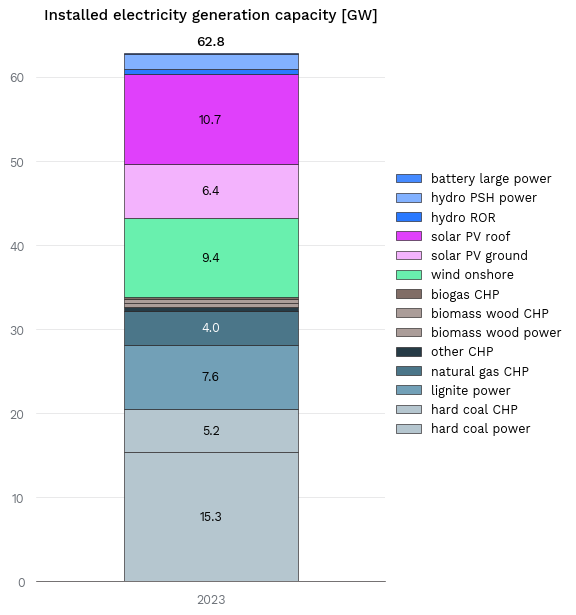

In [27]:
from pypsa_pl_mini.plot_outputs import plot_installed_capacities

fig, df = plot_installed_capacities(network)

df = append_annual_sum(df)
df

#### Plot electricity generation mix

,year,carrier,value
0,2023,battery large charger,-0.15
1,2023,battery large power,0.13
2,2023,biogas CHP,1.29
3,2023,biomass wood CHP,3.21
4,2023,biomass wood power,2.99
6,2023,hard coal CHP,14.35
7,2023,hard coal power,34.88
8,2023,hydro PSH power,0.99
9,2023,hydro PSH pump,-1.41
10,2023,hydro ROR,2.42


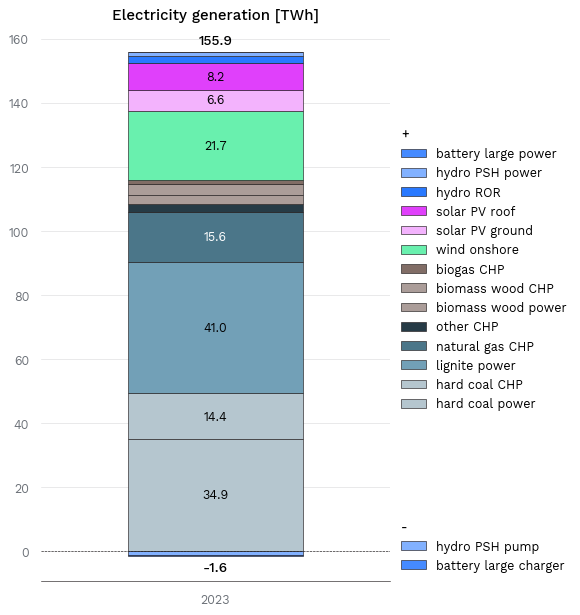

In [28]:
from pypsa_pl_mini.plot_outputs import plot_annual_generation

fig, df = plot_annual_generation(network)

df = append_annual_sum(df)
df

#### Plot fuel consumption and CO2 emissions

,year,carrier,value
1,2023,biogas substrate supply,12.5
4,2023,biomass wood supply,78.2
7,2023,hard coal supply,546.1
9,2023,lignite supply,424.2
11,2023,natural gas supply,117.3
13,2023,other fuel supply,25.5
0,2023,SUM,1203.8


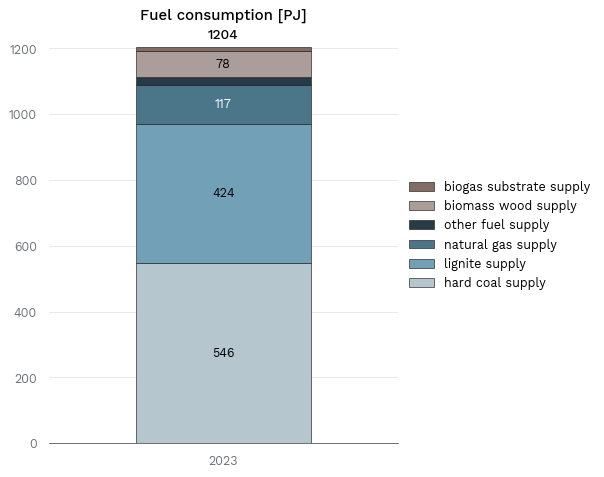

In [29]:
from pypsa_pl_mini.plot_outputs import plot_fuel_consumption

fig, df = plot_fuel_consumption(network)

df = append_annual_sum(df)
df

,year,carrier,value
7,2023,hard coal supply,51.58
9,2023,lignite supply,47.13
11,2023,natural gas supply,6.52
13,2023,other fuel supply,2.27
0,2023,SUM,107.50


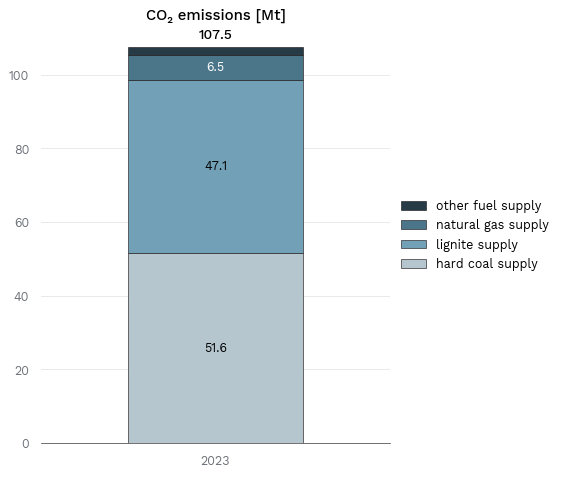

In [30]:
from pypsa_pl_mini.plot_outputs import plot_co2_emissions

fig, df = plot_co2_emissions(network)

df = append_annual_sum(df)
df

#### Plot hourly electricity generation

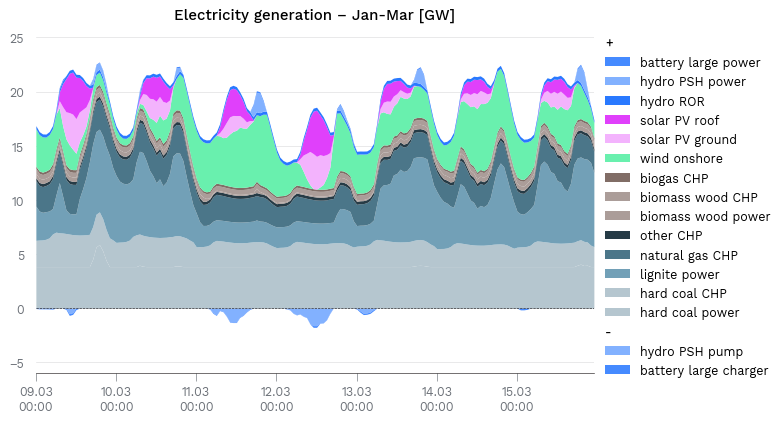

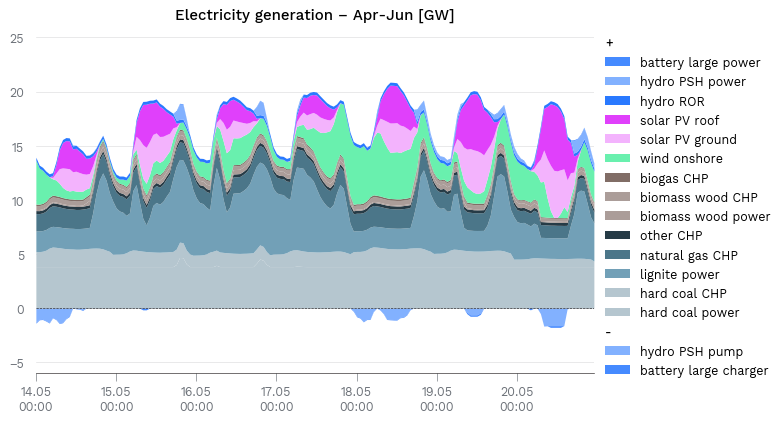

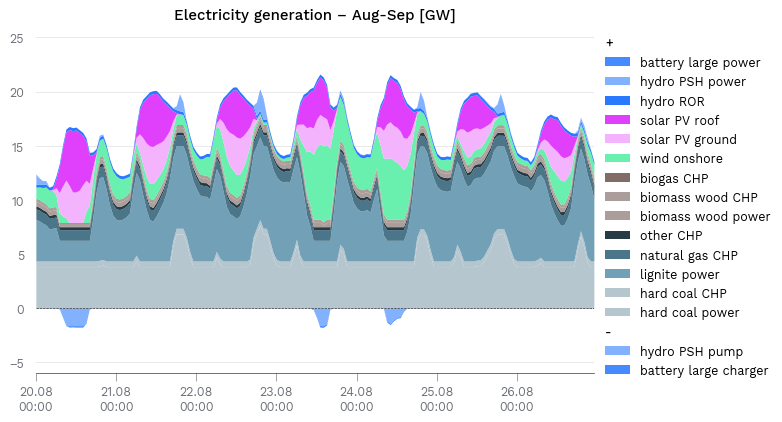

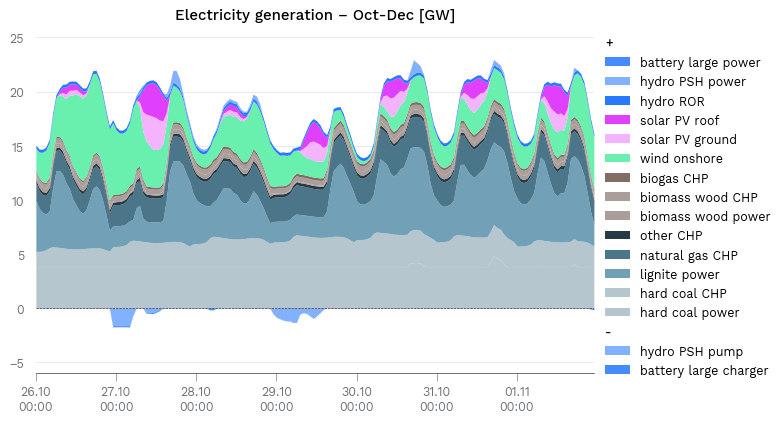

In [31]:
from pypsa_pl_mini.plot_outputs import plot_hourly_generation

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

fig, df = plot_hourly_generation(network, subperiods=subperiods, ylim=(-6,26))

In [32]:
df

carrier,battery large charger,battery large power,biogas CHP,biomass wood CHP,biomass wood power,hard coal CHP,hard coal power,hydro PSH power,hydro PSH pump,hydro ROR,lignite power,natural gas CHP,other CHP,solar PV ground,solar PV roof,wind onshore
2012-03-09 00:00:00,-0.035,0.0,0.212,0.442,0.4,2.429,3.838,0.0,0.0,0.276,3.160,2.351,0.275,0.0,0.0,3.474
2012-03-09 01:00:00,-0.062,0.0,0.213,0.442,0.4,2.450,3.838,0.0,0.0,0.276,2.682,2.366,0.275,0.0,0.0,3.360
2012-03-09 02:00:00,-0.063,0.0,0.215,0.442,0.4,2.465,3.838,0.0,0.0,0.276,2.550,2.376,0.275,0.0,0.0,3.256
2012-03-09 03:00:00,-0.065,0.0,0.220,0.442,0.4,2.525,3.838,0.0,0.0,0.276,2.550,2.419,0.275,0.0,0.0,3.132
2012-03-09 04:00:00,-0.072,0.0,0.230,0.442,0.4,2.660,3.838,0.0,0.0,0.276,2.478,2.515,0.275,0.0,0.0,3.199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-01 19:00:00,0.000,0.0,0.207,0.442,0.4,2.372,3.838,0.0,-0.0,0.276,6.972,2.310,0.275,0.0,0.0,4.592
2012-11-01 20:00:00,0.000,0.0,0.205,0.442,0.4,2.340,3.838,0.0,-0.0,0.276,6.092,2.287,0.275,0.0,0.0,4.771
2012-11-01 21:00:00,0.000,0.0,0.198,0.442,0.4,2.253,3.838,0.0,-0.0,0.276,4.578,2.225,0.275,0.0,0.0,4.856
2012-11-01 22:00:00,-0.082,0.0,0.184,0.442,0.4,2.080,3.838,0.0,0.0,0.276,3.039,2.102,0.275,0.0,0.0,4.884


#### Plot marginal cost of electricity production

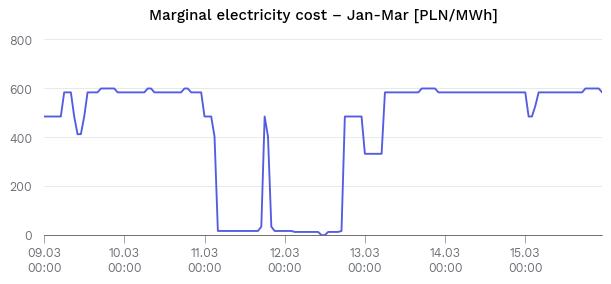

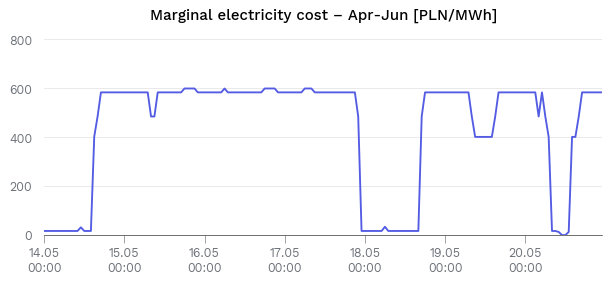

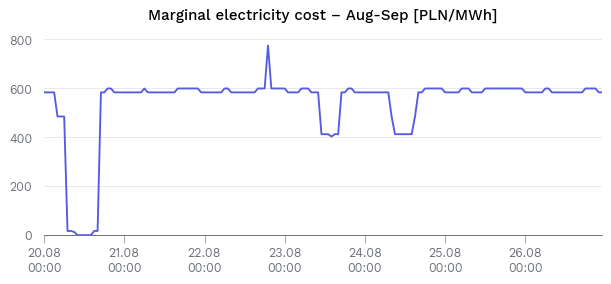

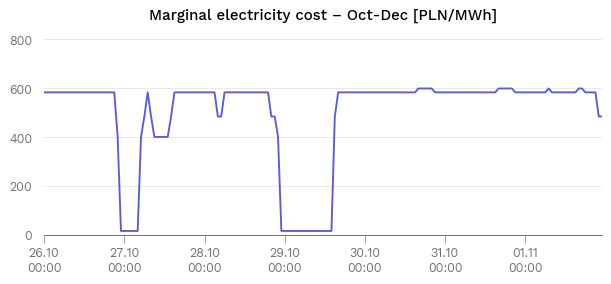

In [33]:
from pypsa_pl_mini.plot_outputs import plot_prices

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

fig, df = plot_prices(network, subperiods=subperiods, ylim=(0, 850))

df_price = df.copy()

Avg. electricity price (simple): 477.8 PLN/MWh


,metric,value
0,Avg. unit cost,566.3
1,Avg. price,487.9


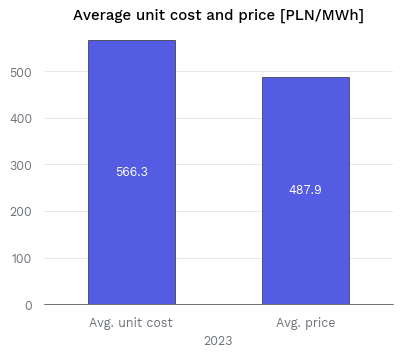

In [34]:
from pypsa_pl_mini.plot_outputs import plot_average_unit_cost_and_price

fig, df = plot_average_unit_cost_and_price(network)

# TGE-DA 2023 mean: 530 PLN/MWh

# Calculate simple (i.e. non-weighted) avg. market price
mean_price = df_price.mean().values[0].round(1)
print("Avg. electricity price (simple):", mean_price, "PLN/MWh")

df

#### Plot operational costs

,year,aggregation,value
1,2023,biomass and biogas CHP,0.15
2,2023,biomass and biogas supply,3.24
3,2023,biomass power,0.08
4,2023,hard coal CHP,0.29
5,2023,hard coal power,0.70
6,2023,hard coal supply,37.80
7,2023,hydro PSH,0.01
8,2023,lignite power,0.82
9,2023,lignite supply,21.92
10,2023,natural gas CHP,0.44


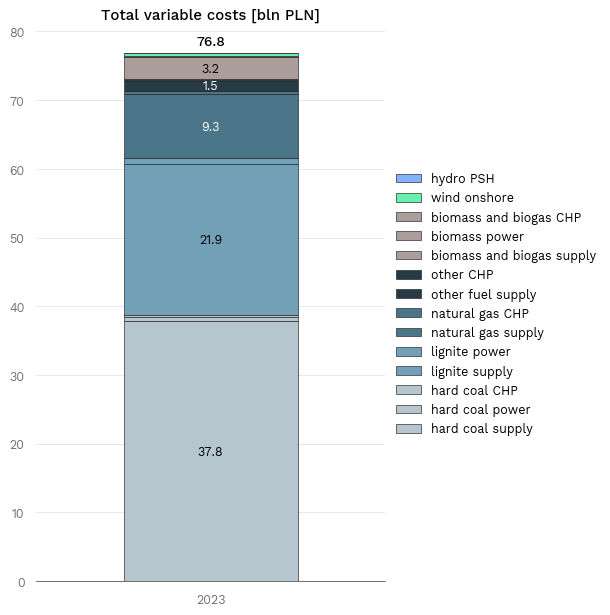

In [35]:
from pypsa_pl_mini.plot_outputs import plot_opex

fig, df = plot_opex(network)

# The sum of OPEX is the objective function's value
df = append_annual_sum(df)

df

#### Plot revenues net costs

,year,aggregation,value
0,2023,battery large,0.04
1,2023,biomass and biogas CHP,-0.16
3,2023,biomass power,0.43
5,2023,hard coal CHP,-6.82
6,2023,hard coal power,-8.43
8,2023,hydro PSH,0.43
9,2023,hydro ROR,1.16
10,2023,lignite power,-0.48
12,2023,natural gas CHP,-2.39
14,2023,other CHP,-0.58


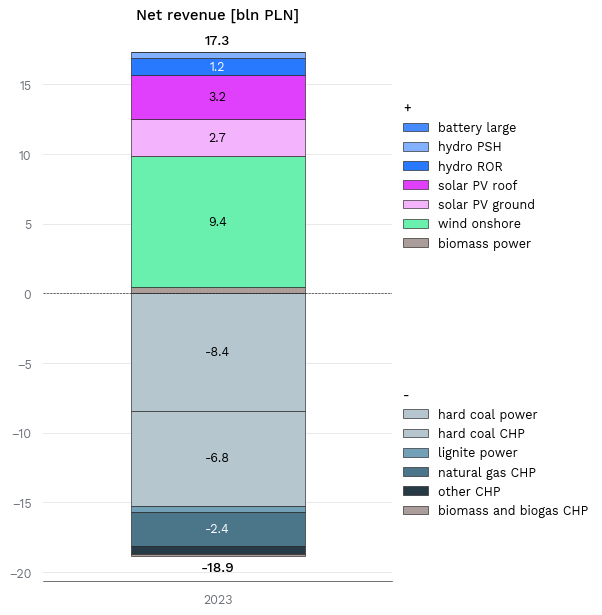

In [36]:
from pypsa_pl_mini.plot_outputs import plot_net_revenues

fig, df = plot_net_revenues(network, costs=["OPEX"])

df = append_annual_sum(df)

df

# CHP plants have negative net revenues as we do not take into account revenues from heat sales

### Sensitivity analysis: conventional baseload

In [37]:
import logging
from matplotlib import pyplot as plt
from io import BytesIO
import ipywidgets as widgets
from ipywidgets import interact_manual

from pypsa_pl_mini.helper_functions import suppress_stdout

In [38]:
default_p_min_pu = 0.25

def update_p_min_pu_of_public_power_plants(network, p_min_pu=default_p_min_pu):
    is_public_pp = network.links["carrier"].isin(
        ["hard coal power", "lignite power", "biomass wood power"]
    ) & (network.links["qualifier"] == "public")
    if network.meta["reverse_links"]:
        network.links.loc[is_public_pp, "p_max_pu"] = -p_min_pu
    else:
        network.links.loc[is_public_pp, "p_min_pu"] = p_min_pu
    return network

In [39]:
from pypsa_pl_mini.plot_outputs import plot_curtailed_vres_energy

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

figure_width = 6

def list_plotting_tasks():
    return [
        (
            plot_hourly_generation,
            dict(subperiods=[subperiods[1]], ylim=(-6, 26), figsize=(figure_width, 6)),
        ),
        (
            plot_prices,
            dict(subperiods=[subperiods[1]], ylim=(0, 850), figsize=(figure_width, 4)),
        ),
        (
            plot_annual_generation,
            dict(ylim=(-11, 171), figsize=(figure_width, 6)),
        ),
        (
            plot_curtailed_vres_energy,
            dict(ylim=(0, 5.5), figsize=(figure_width, 4)),
        ),
        (
            plot_co2_emissions,
            dict(ylim=(0, 125), figsize=(figure_width, 5)),
        ),
        (
            plot_opex,
            dict(ylim=(0, 85), figsize=(figure_width, 5)),
        ),
        (
            plot_average_unit_cost_and_price,
            dict(ylim=(0, 850), figsize=(figure_width, 4)),
        ),
        (
            plot_net_revenues,
            dict(ylim=(-36, 36), figsize=(figure_width, 5)),
        ),
    ]

In [40]:
def make_images(network):
    imgs = []
    for plot_func, kwargs in list_plotting_tasks():
        try:
            fig, _ = plot_func(network, **kwargs)
            img = BytesIO()
            fig.tight_layout()
            px_per_inch = 85
            fig.savefig(img, format="png", dpi=px_per_inch * 2)
            plt.close()
            img.seek(0)
            img = widgets.Image(value=img.read(), format="png")
            width, height = kwargs["figsize"]
            img.layout = widgets.Layout(
                height=f"{px_per_inch*height}px",
                width=f"{px_per_inch*width}px",
                margin="5px 5px 5px 5px",
                border="solid 1.5px darkgrey",
            )
            imgs.append(img)
        except:
            logging.warning(f"Failed to create image with '{plot_func.__name__}'")
    return imgs


def make_widgets(values, images):
    header_layout = widgets.Layout(
        border="solid 1.5px darkgrey",
        margin="5px 5px 5px 5px",
        padding="5px 5px 5px 5px",
    )
    column_layout = widgets.Layout(
        margin="10px 5px 10px 5px",
        padding="5px 5px 5px 5px",
    )
    columns = []
    for key in ["previous", "current"]:
        html = f"""
            <center>
                <div><b>{key.upper()} CALCULATION</b></div>
                <div>p_min_pu: {values[key]['p_min_pu']:.0%}</div>
            </center>"""
        header = widgets.HTML(value=html)
        header.layout = header_layout
        column = widgets.VBox([header] + images[key])
        column.layout = column_layout
        columns.append(column)

    return widgets.HBox(columns)

In [41]:
values = {"previous": None, "current": {"p_min_pu": default_p_min_pu}}
images = {"previous": None, "current": make_images(network)}


@interact_manual(
    p_min_pu=widgets.FloatSlider(default_p_min_pu, min=0, max=0.301, step=0.01)
)
def recalculate(p_min_pu):

    values["previous"] = values["current"]
    images["previous"] = images["current"]

    update_p_min_pu_of_public_power_plants(network, p_min_pu=p_min_pu)

    with suppress_stdout():
        optimise_network(network, params)

    logging.info("Generating result visualisations...")

    values["current"] = {"p_min_pu": p_min_pu}
    images["current"] = make_images(network)

    return make_widgets(values, images)

interactive(children=(FloatSlider(value=0.25, description='p_min_pu', max=0.301, step=0.01), Button(descriptio…